In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import sys

In [2]:
tf.debugging.set_log_device_placement(False)

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Found GPU at: /device:GPU:0
Num GPUs Available:  1


# Importing My Own Functions

In [4]:
import run_fast_dir

In [5]:
tf.__version__

'2.8.0-dev20211216'

# Size of Data in training and validation Sets

In [6]:
sub_folders, and_files = run_fast_dir.run_fast_scandir('./Data/imagewoof-320/train',['.jpeg'])
print(f'The Training Dataset contains {len(and_files)} images')

The Training Dataset contains 12454 images


In [7]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dir = './Data/imagewoof-320/train'

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                          shuffle=True,
                                                          batch_size=BATCH_SIZE,
                                                          image_size=IMG_SIZE)

Found 12454 files belonging to 10 classes.


In [8]:
sub_folders, and_files = run_fast_dir.run_fast_scandir('./Data/imagewoof-320/val',['.jpeg'])
print(f'The Validation Dataset contains {len(and_files)} images')

The Validation Dataset contains 500 images


In [9]:
validation_dir = './Data/imagewoof-320/val'

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(validation_dir,
                                                              shuffle=True,
                                                              batch_size=BATCH_SIZE,
                                                              image_size=IMG_SIZE)

Found 500 files belonging to 10 classes.


# Moving 20% of validation data to a test set
We do not have a test set therefore will set aside some of the validation data to a test set, this will still overfit our model since our validation data is only 500 images however it is important to see how much of an improvement we can make (will evaluate further down the line).

In [10]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [11]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 13
Number of test batches: 3


# Buffered Prefetching
Per [Data Performance Guide](https://www.tensorflow.org/guide/data_performance)I/O can become a problem for the execution time of a training step. Therefore we will need something that enables the configuration of the dataset for peak erformance.

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

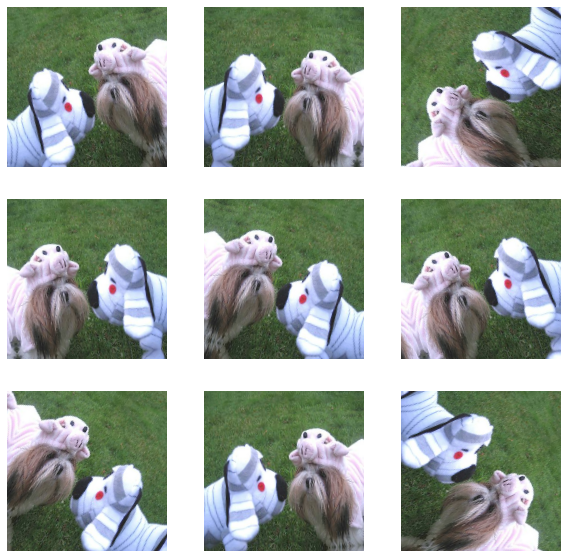

In [14]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [15]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [16]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)

# Feature Extraction
## Freeze the convolutional base

In [17]:
IMG_SHAPE = IMG_SIZE + (3,)
res_net2 = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

for layer in res_net2.layers:
  layer.trainable = False

In [19]:
x = tf.keras.layers.Flatten()(res_net2.output)
x = tf.keras.layers.Dense(1000, activation='relu')(x)
predictions = tf.keras.layers.Dense(10, activation = 'relu')(x)

In [20]:
base_learning_rate = 0.01
head_model = tf.keras.Model(inputs = res_net2.input, outputs = predictions)
head_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
                   loss=tf.keras.losses.sparse_categorical_crossentropy, 
                   metrics=['accuracy'])

In [21]:
len(head_model.trainable_variables)

4

In [22]:
initial_epochs = 10
loss0, accuracy0 = head_model.evaluate(validation_dataset)

13/13 [==============================] - 6s 103ms/step - loss: 10.6333 - accuracy: 0.0693


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 10.63
initial accuracy: 0.07


In [24]:
history = head_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
390/390 [==============================] - 27s 62ms/step - loss: 14.3692 - accuracy: 0.1041 - val_loss: 14.4823 - val_accuracy: 0.1015
Epoch 2/10
390/390 [==============================] - 24s 61ms/step - loss: 14.4294 - accuracy: 0.1044 - val_loss: 14.4823 - val_accuracy: 0.1015
Epoch 3/10
390/390 [==============================] - 24s 62ms/step - loss: 14.4294 - accuracy: 0.1044 - val_loss: 14.4425 - val_accuracy: 0.1040
Epoch 4/10
390/390 [==============================] - 24s 62ms/step - loss: 14.4294 - accuracy: 0.1044 - val_loss: 14.5222 - val_accuracy: 0.0990
Epoch 5/10
390/390 [==============================] - 24s 62ms/step - loss: 14.4294 - accuracy: 0.1044 - val_loss: 14.5222 - val_accuracy: 0.0990
Epoch 6/10
390/390 [==============================] - 25s 63ms/step - loss: 14.4294 - accuracy: 0.1044 - val_loss: 14.4425 - val_accuracy: 0.1040
Epoch 7/10
390/390 [==============================] - 25s 63ms/step - loss: 14.4294 - accuracy: 0.1044 - val_loss: 14.3627 -

In [25]:
Trial_num = 1
output_path = './Results/'
folder_name = f'Trial{str(Trial_num)}'

if not os.path.exists(output_path + folder_name):
    os.makedirs(output_path + folder_name)

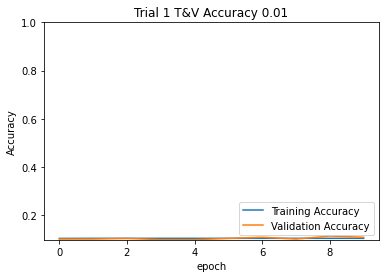

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#plt.figure(figsize=(8, 8))
#plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title(f'Trial {Trial_num} T&V Accuracy {base_learning_rate}')
plt.savefig(output_path + '/' + folder_name + '/' + f'Trial {Trial_num} T&V Accuracy {base_learning_rate}.jpeg')
plt.xlabel('epoch')
plt.show()
#plt.close()

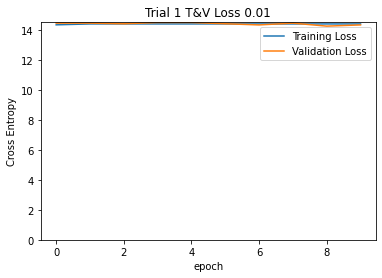

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']

#plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title(f'Trial {Trial_num} T&V Loss {base_learning_rate}')
plt.savefig(output_path + '/' + folder_name + '/' + f'Trial {Trial_num} T&V Loss {base_learning_rate}.jpeg')
plt.xlabel('epoch')
plt.show()
#plt.close()

# Evaluation and prediction

In [30]:
loss, accuracy = head_model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

3/3 [==============================] - 0s 50ms/step - loss: 14.9428 - accuracy: 0.0729
Test accuracy : 0.0729166641831398
